# 3D Reconstruction
Now that we have the silhuettes we can now extract the visual hull of the object. Do so we need the camera intrinsic parameters and the extrinsic paramters. Our simulation pipeline already provides us with a json file for that. A python script then can be ran to extract the camera intrinsics

In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt

from src.camera_data import CamerasData, IntrinsicParameters
from src.scans import Scans
from src.convex_hull import project_scan, project_all_scans, threshold_volume
from src.mesh import build_mesh
from src.constants import gb_cmap
from src.camera_data import look_at, circular_extrinsics

example_camera = 0

## 1. Data Classes
To do the reconstruction we need to organize our data into clear but usefull classes. This will include our Camera Data (`CameraData`) and our Pictures (`Scans`)

### 1.1. Camera Data
For the reconstruction we need:
- Camera Intrinsics
- Extrinsics Parameters

The camera intrinsics are defined by the matrix K (extracted by the `camera_calibration.py`) and the extrinsics are defined by the individual camera positions (4x4 matrix). All of this is managed by the class ```CameraData```

In [7]:
# Example usage:
radius_m = 0.5
num_cameras = 12
extrinsics = circular_extrinsics(radius_m, num_cameras, z=0.0)

print("Extrinsics shape:", extrinsics.nr_cameras)
print("First extrinsic:\n", extrinsics.extrinsics[0].matrix)


Extrinsics shape: 12
First extrinsic:
 [[ 0.   1.  -0.   0. ]
 [-0.   0.  -1.   0. ]
 [-1.   0.   0.   0.5]
 [ 0.   0.   0.   1. ]]


In [10]:
intrinsic = IntrinsicParameters("./figures/calibration_pictures/brio300/output/camera_matrix.txt")
print("Intrinsic matrix:\n", intrinsic.matrix)

Intrinsic matrix:
 [[766.17135704   0.         365.69521395]
 [  0.         761.76593763 187.02850687]
 [  0.           0.           1.        ]]


In [11]:
camera_data = CamerasData(intrinsic, extrinsics)

In [12]:
print(f"K Matrix:\n{camera_data.K}\n")
print(f'Extrinsic Matrix of Camera {example_camera}\n{camera_data.get_camera_extrinsics(example_camera)}\n')
print(f'With shape: {camera_data.extrinsics_array.shape}')

K Matrix:
[[766.17135704   0.         365.69521395]
 [  0.         761.76593763 187.02850687]
 [  0.           0.           1.        ]]

Extrinsic Matrix of Camera 0
[[ 0.   1.  -0.   0. ]
 [-0.   0.  -1.   0. ]
 [-1.   0.   0.   0.5]
 [ 0.   0.   0.   1. ]]

With shape: (12, 4, 4)


**Projection Matrix**<br>
By combining both matrices we can have the projection matrix

In [13]:
P = camera_data.P(0)

print(f'Projection Matyrix of Camera 0\n{P}\n')
print(f'With shape: {P.shape}')

Projection Matyrix of Camera 0
[[-3.65695214e+02  7.66171357e+02  0.00000000e+00  1.82847607e+02]
 [-1.87028507e+02  0.00000000e+00 -7.61765938e+02  9.35142534e+01]
 [-1.00000000e+00  0.00000000e+00  0.00000000e+00  5.00000000e-01]]

With shape: (3, 4)


### 1.2 Scans
Scans should have all the segemntations from the pictures taken. It holds the data as a binary array [0 or 1]

In [15]:
scans = Scans("./figures/demo/aligned")

Number of scans: 12
Dimension of each scan: (1720, 2580)
Values in the first scan: [0 1]


(np.float64(-0.5), np.float64(2579.5), np.float64(1719.5), np.float64(-0.5))

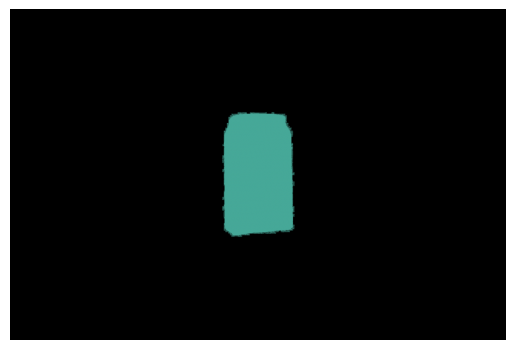

In [16]:
print(f"Number of scans: {scans.nr_positions}")
print(f"Dimension of each scan: {scans.scan_shape}")
print(f"Values in the first scan: {np.unique(scans.scan(0))}")

plt.imshow(scans.scan(0), cmap=gb_cmap)
plt.axis('off')